# Bayesian Optimisation with Pyro 1.0  using GPs on the Branin-Hoo example

**Goal**: apply Bayesian Optimisation (BO) strategy to minimize Branin-Hoo function with pyro.

The Branin-Hoo function:

$f(x) = a(x_2 - bx_1^2 + cx_1 - r)^2 + s(1-t)\cos(x_1) + s$

In [1]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

pyro.enable_validation(True)

In [2]:
print("torch:", torch.__version__)
print("pyro:", pyro.__version__)

if not pyro.__version__.startswith("1"):
    raise ValueError("incompatible version of pyro")

torch: 1.3.0.post2
pyro: 1.0.0


In [3]:
seed_number = 444

def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
set_random_seed(seed_number)

## Objective function

In [4]:
const_x1_min = -5
const_x1_max = 10

const_x2_min = 0
const_x2_max = 15

def branin_hoo(x):
    """ Compute Branin-Hoo function for fixed constants """
    
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    
    x1 = x[..., 0]
    x2 = x[..., 1]
    
    return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*torch.cos(x1) + s

# Checking LMs
assert np.allclose(
        branin_hoo(torch.stack((
            torch.tensor([-math.pi, math.pi, 9.42478]), 
            torch.tensor([12.275, 2.275, 2.475])), dim=1)).numpy(),
        np.array([0.397887, 0.397887, 0.397887], dtype=np.float32), rtol=1e-6)

## Visualisation of the objective function and training data

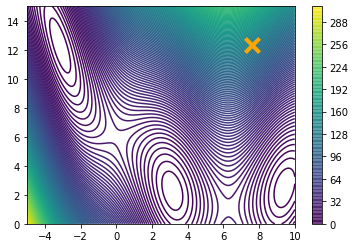

In [5]:
train_cnt = 1

X1_train = torch.tensor([x for x in np.random.uniform(low=const_x1_min, high=const_x1_max, size=train_cnt)])
X2_train = torch.tensor([x for x in np.random.uniform(low=const_x2_min, high=const_x2_max, size=train_cnt)])
X_train = torch.stack((X1_train, X2_train), dim=1)
Y_train = branin_hoo(X_train)

def plot_target():

    steps = 1000
    strides = 200

    X1 = torch.linspace(const_x1_min, const_x1_max, steps)
    X2 = torch.linspace(const_x2_min, const_x2_max, steps)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    Z_mesh = branin_hoo(torch.stack((X1_mesh, X2_mesh), dim=2))

    plt.contour(X1_mesh, X2_mesh, Z_mesh, strides)
    plt.colorbar()
    
plot_target()
    
# Plotting training data
plt.scatter(X1_train, X2_train, marker="x", s=200, c='orange', zorder=2, linewidth=4);

# Constructing BO strategy

### Defining acquisition function

In [6]:
def lower_confidence_bound(gpmodel, x, kappa=2):
    """
    Lower Confidence Bound (LCB): $\alpha(x)=\mu(x) - \kappa\sigma(x)$
    
    """
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2

def expected_improvement(gpmodel, x):
    """
    Brooks' implementation of expected improvement (EI).
    
    """
    y_min = gpmodel.y.min()
    
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    
    sigma = variance.sqrt()
    
    delta = y_min - mu
    
    EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
    
    return -EI

def acquisition_func(gpmodel, x, af='EI'):
    """
    Defines acquisition function.
    """
    
    if af == "EI":
        return expected_improvement(gpmodel, x)
    
    elif af == "LCB":
        return lower_confidence_bound(gpmodel, x)
    
    else:
        return None

## Minimalistic BO Algorithm

### Function to find minimizing points for an acquisition function

In [7]:
def find_a_candidate(gpmodel, x_init):
    
    # Creating constrains
    constraint_x1 = constraints.interval(const_x1_min, const_x1_max)
    constraint_x2 = constraints.interval(const_x2_min, const_x2_max)
    
    # transform x_init to an unconstrained domain as we use an unconstrained optimizer
    unconstrained_x1_init = transform_to(constraint_x1).inv(x_init[:, 0])
    unconstrained_x2_init = transform_to(constraint_x2).inv(x_init[:, 1])
    x_uncon_init = torch.stack((unconstrained_x1_init, unconstrained_x2_init), dim=1)
    
    x_uncon = x_uncon_init.clone().detach().requires_grad_(True)
    
    # unconstrained minimiser
    minimizer = optim.Adam([x_uncon])

    def closure():
        # clear gradients
        minimizer.zero_grad()
                
        x1_tmp = transform_to(constraint_x1)(x_uncon[:, 0])
        x2_tmp = transform_to(constraint_x2)(x_uncon[:, 1])
        x = torch.stack((x1_tmp, x2_tmp), dim=1)
        
        y = acquisition_func(gpmodel, x)
        
        autograd.backward(x_uncon, autograd.grad(y, x_uncon))
                
        return y
    
    for _ in range(1000):
        minimizer.step(closure)
        
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x1_tmp = transform_to(constraint_x1)(x_uncon[:, 0])
    x2_tmp = transform_to(constraint_x2)(x_uncon[:, 1])
    
    x = torch.stack((x1_tmp, x2_tmp), dim=1)
    
    return x.detach()

### A single step of BO

LBFGS optimiser used in `find_a_candidate` is a gradient based method and can get stuck at a local minimum. A simple approach to address this is to try several attemps (5) to find the best candidate to minimize the acquisition function.

In [8]:
def next_x(gpmodel, num_candidates=5, svi_mode=False):
    
    candidates = []
    values = []
    
    # take the best (lowest) point as the first attempt
    x_init = gpmodel.X[[gpmodel.y.argmin()], :].detach().requires_grad_(True)
        
    for i in range(num_candidates):
        
        x = find_a_candidate(gpmodel, x_init)
        
        if svi_mode:
            sample_cnt = 10
            y_avg = 0
            for _ in range(sample_cnt):
                 y_avg += acquisition_func(gpmodel, x)
            y = y_avg / sample_cnt
            
        else:
            y = acquisition_func(gpmodel, x)
    
        candidates.append(x)
        values.append(y)
        
        # a new random attempt initial point
        x_init = torch.stack((
                x[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                x[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
    
        print("Candidate ", i, x, y)
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    
    print("Result: ", candidates[argmin], values[argmin])
    
    return candidates[argmin], candidates

### Updating posterior

Each time we evaluate `f` at a new value x, we update the `gpmodel`.

In [9]:
def update_posterior(gpmodel, x_new, svi_mode=False):
        
    # evaluate f at new point
    bh_y = branin_hoo(x_new) 
    
    # incorporate new evaluation
    X = torch.cat([gpmodel.X, x_new]) 
    y = torch.cat([gpmodel.y, bh_y])
        
    gpmodel.set_data(X, y)
    
    # optimising hyper paramters
    
    optimiser = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    
    if svi_mode:
        loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
        gp.util.train(gpmodel, optimiser, loss_fn, num_steps=2000)
    else:
        gp.util.train(gpmodel, optimiser) 

### Visualising step

In [10]:
def plot_function(f, x1_min, x1_max, x2_min, x2_max, n_points=100, strides=200):
    
    X1 = torch.linspace(x1_min, x1_max, n_points)
    X2 = torch.linspace(x2_min, x2_max, n_points)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    
    Z_mesh = f(torch.stack((X1_mesh.flatten(), X2_mesh.flatten()), dim=1)).reshape(n_points,n_points)
    
    plt.contourf(X1_mesh, X2_mesh, Z_mesh, strides)
    plt.set_cmap('jet')
    plt.colorbar()
    
def visualise_step(gp_model_before, xcans, gp_model_after):
    
    plt.figure(figsize=(15, 3)) 
    
    plt.subplot(1,5,1)
    plt.title("Acquisition \n(Before)")
    
    plt.scatter(gp_model_before.X.numpy().T[0], 
                gp_model_before.X.numpy().T[1], 
                marker="x", s=200, c='orange', zorder=2, linewidth=4);
    
    #  marking candidates
    for can in xcans:
        plt.scatter(can.numpy().T[0], 
            can.numpy().T[1], 
            marker="x", s=200, c='white', zorder=3, linewidth=4);
    
    with torch.no_grad(): 
        f = lambda x: acquisition_func(gp_model_before, x)
        plot_function(f, const_x1_min, const_x1_max, const_x2_min, const_x2_max)
    
    plt.subplot(1,5,2)
    plt.title("New point on the \ntarget function's landscape")
    plot_target()
    plt.scatter(gp_model_after.X.numpy().T[0][-1], 
            gp_model_after.X.numpy().T[1][-1], 
            marker="x", s=200, c='black', zorder=3, linewidth=4);
    
    plt.subplot(1,5,3)
    plt.title("Acquisition \n(After)")
    
    plt.scatter(gp_model_after.X.numpy().T[0][-1], 
                gp_model_after.X.numpy().T[1][-1], 
                marker="x", s=200, c='black', zorder=3, linewidth=4);
    
    with torch.no_grad(): 
        f = lambda x: acquisition_func(gp_model_after, x)
        plot_function(f, const_x1_min, const_x1_max, const_x2_min, const_x2_max)
            
    with torch.no_grad(), gp_model_after._pyro_context:
        plt.subplot(1,5,4)
        plt.title("GP mean")
        f = lambda x: gp_model_after(x)[0]
        plot_function(f, const_x1_min, const_x1_max, const_x2_min, const_x2_max)

        plt.subplot(1,5,5)
        plt.title("GP variance")
        f = lambda x: gp_model_after(x)[1]
        plot_function(f, const_x1_min, const_x1_max, const_x2_min, const_x2_max)


# Deterministic approach

--------------------------------------------------
BO STEP:  0
--------------------------------------------------
Candidate  0 tensor([[ 8.2224, 12.3194]]) tensor([-0.6907], grad_fn=<NegBackward>)
Candidate  1 tensor([[-3.7622, 12.8007]]) tensor([-0.], grad_fn=<NegBackward>)
Candidate  2 tensor([[ 6.9584, 12.3194]]) tensor([-0.6907], grad_fn=<NegBackward>)
Candidate  3 tensor([[-0.1752,  3.0097]]) tensor([-0.], grad_fn=<NegBackward>)
Candidate  4 tensor([[ 2.8518, 13.8603]]) tensor([-0.], grad_fn=<NegBackward>)
Result:  tensor([[ 6.9584, 12.3194]]) tensor([-0.6907], grad_fn=<NegBackward>)
--------------------------------------------------
BO STEP:  1
--------------------------------------------------
Candidate  0 tensor([[ 6.6824, 10.5496]]) tensor([-3.4213], grad_fn=<NegBackward>)
Candidate  1 tensor([[0.4859, 5.5170]]) tensor([-0.], grad_fn=<NegBackward>)
Candidate  2 tensor([[6.3900, 2.4362]]) tensor([-0.], grad_fn=<NegBackward>)
Candidate  3 tensor([[ 6.7980, 10.5446]]) tensor([-3.

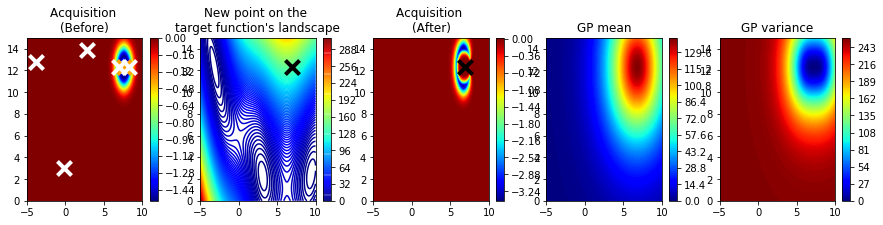

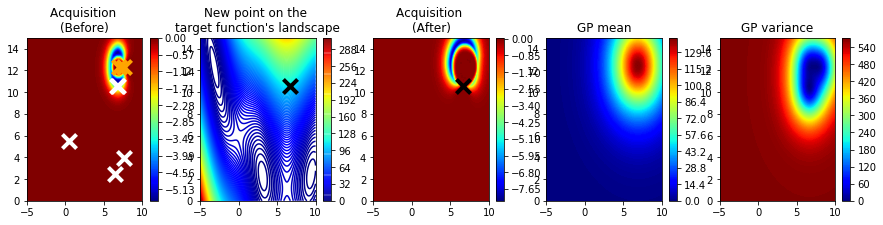

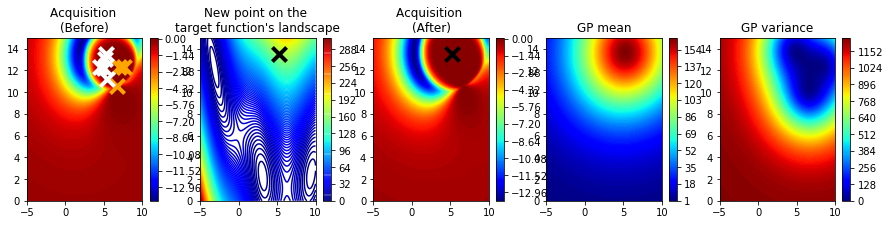

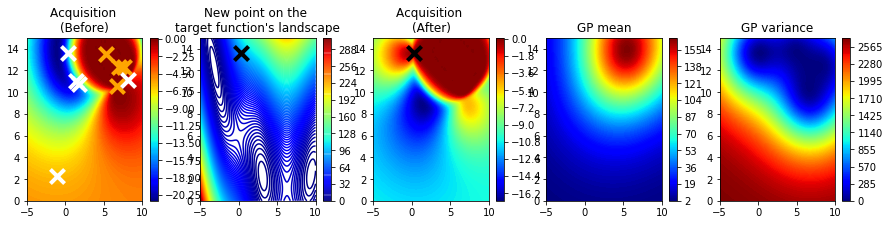

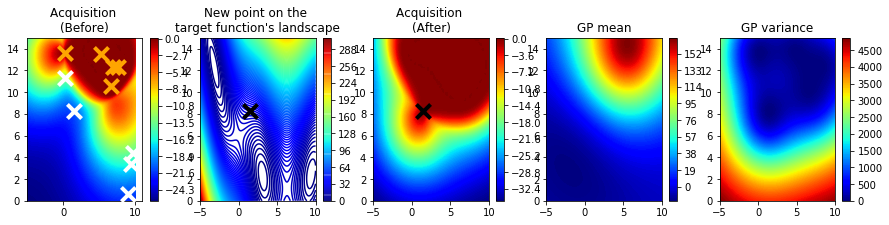

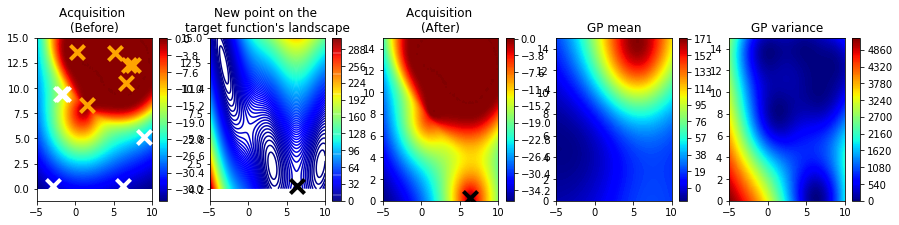

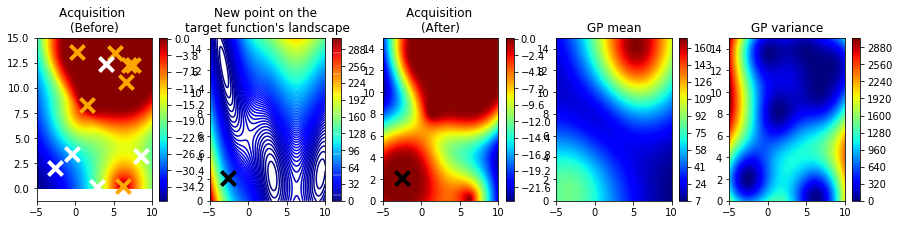

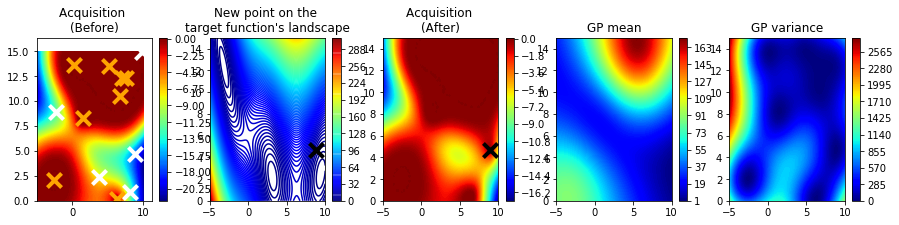

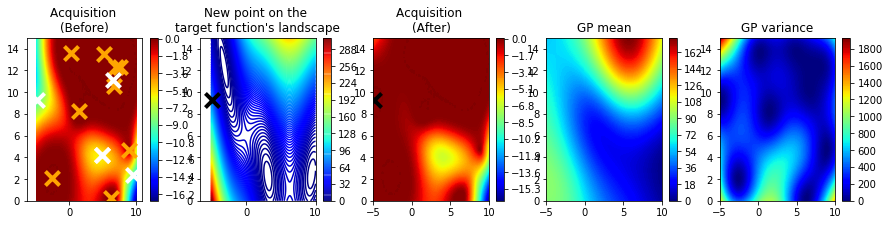

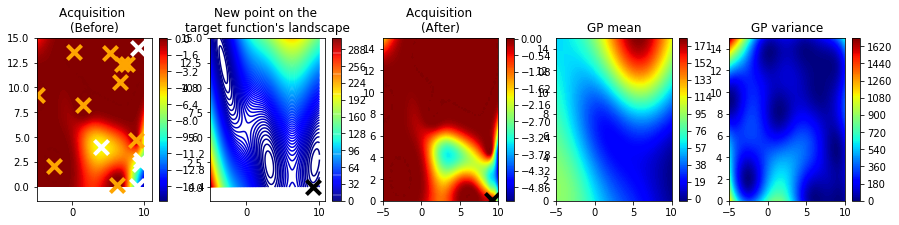

In [13]:
set_random_seed(333)

gp_model = gp.models.GPRegression(X_train, Y_train, 
                                 gp.kernels.Matern52(input_dim=2, 
                                                     lengthscale=5*torch.ones(2),
                                                     variance=torch.tensor(50)), 
                                 noise=torch.tensor(0.1), 
                                 jitter=1.0e-4)

optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.001)
gp.util.train(gp_model, optimizer);

bo_steps = 10

for i in range(bo_steps):
    print("-"*50)
    print("BO STEP: ", i)
    print("-"*50)
    
    gp_model_ = copy.copy(gp_model)
    
    xmin, xcans = next_x(gp_model)
    
    update_posterior(gp_model, xmin)
        
    # visualising the step
    visualise_step(gp_model_, xcans, gp_model)

# Stochastic approach

--------------------------------------------------
BO STEP:  0
--------------------------------------------------
Candidate  0 tensor([[ 8.5121, 12.3194]]) tensor([-6.7283], grad_fn=<DivBackward0>)
Candidate  1 tensor([[1.6559, 8.7181]]) tensor([-14.1131], grad_fn=<DivBackward0>)
Candidate  2 tensor([[-2.0370,  3.2557]]) tensor([-17.7466], grad_fn=<DivBackward0>)
Candidate  3 tensor([[1.0420, 1.5073]]) tensor([-16.2446], grad_fn=<DivBackward0>)
Candidate  4 tensor([[6.6628, 6.6190]]) tensor([-22.8750], grad_fn=<DivBackward0>)
Result:  tensor([[6.6628, 6.6190]]) tensor([-22.8750], grad_fn=<DivBackward0>)
--------------------------------------------------
BO STEP:  1
--------------------------------------------------
Candidate  0 tensor([[5.2466, 4.8834]]) tensor([-21.2140], grad_fn=<DivBackward0>)
Candidate  1 tensor([[-1.3809,  0.2878]]) tensor([-29.9390], grad_fn=<DivBackward0>)
Candidate  2 tensor([[6.9760, 0.7665]]) tensor([-26.5978], grad_fn=<DivBackward0>)
Candidate  3 tensor([[8.

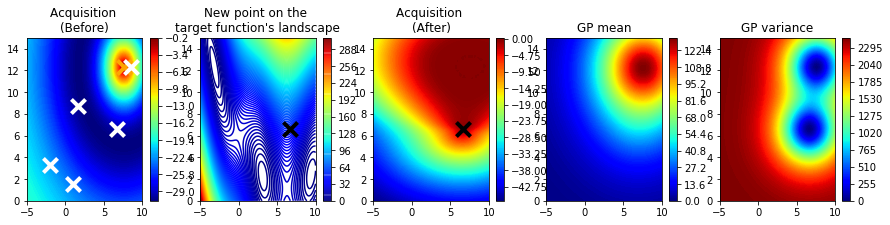

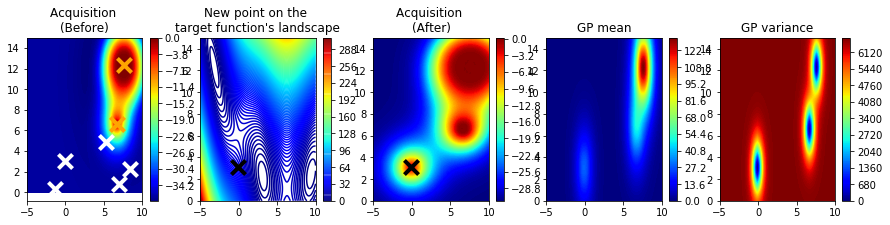

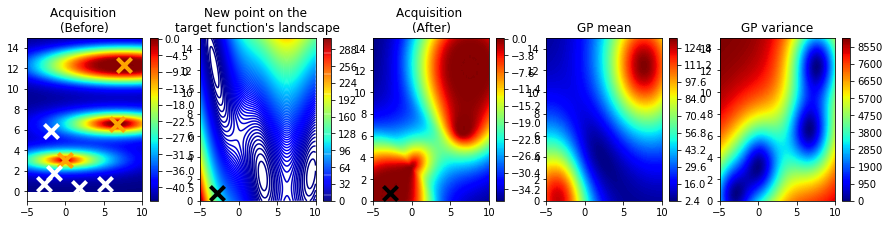

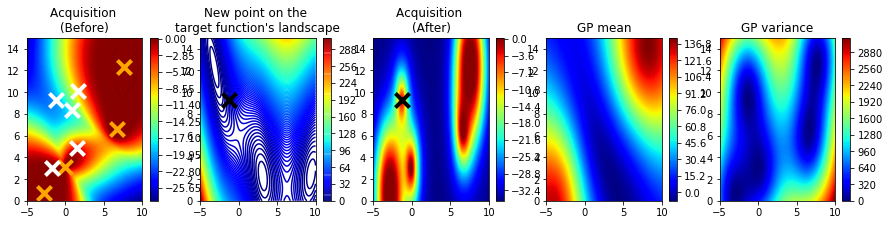

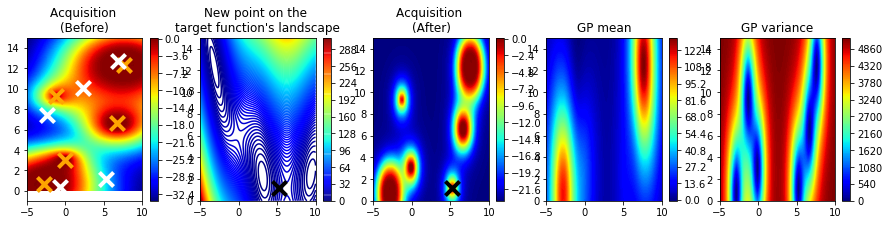

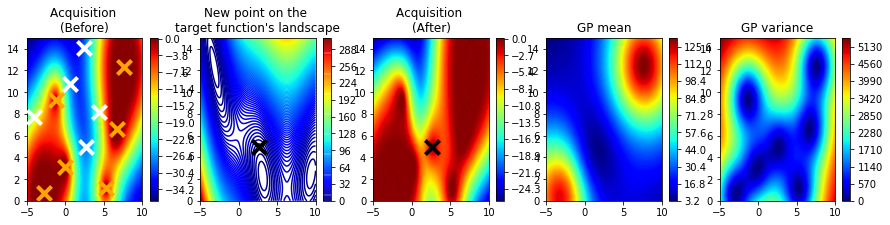

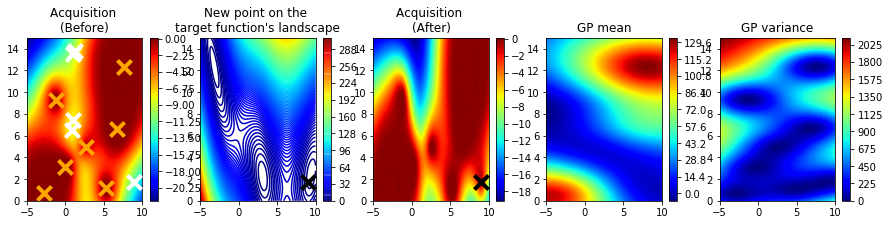

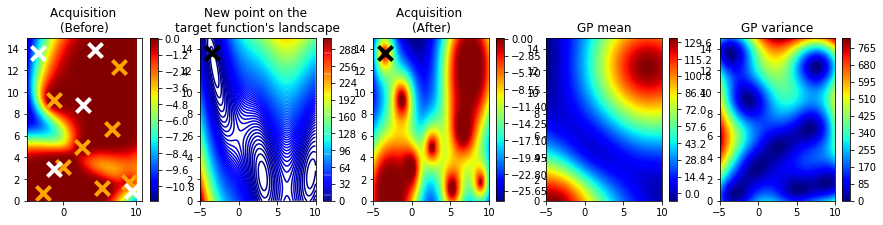

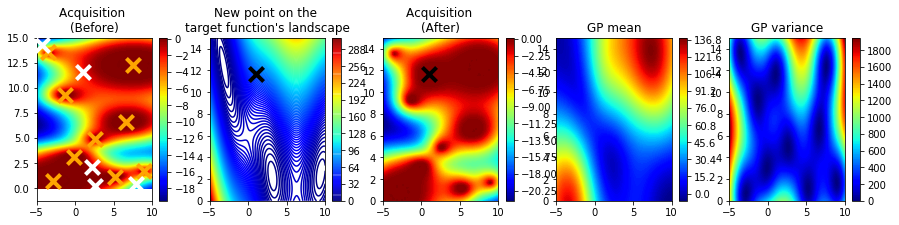

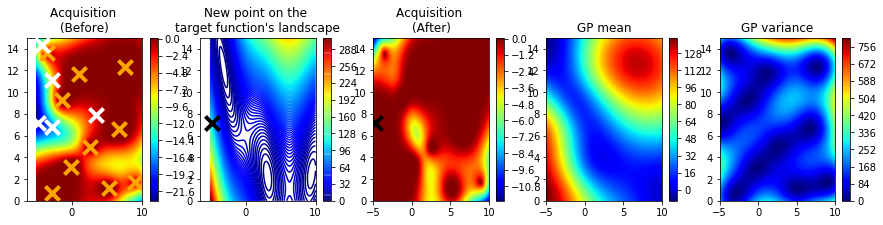

In [14]:
set_random_seed(333)

pyro.clear_param_store()
gp_model_svi = gp.models.GPRegression(X_train, Y_train, gp.kernels.Matern52(input_dim=2, lengthscale=torch.ones(2)))

# Set priors
gp_model_svi.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(3, 1).expand([2]).to_event())
gp_model_svi.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(5, 2))
gp_model_svi.noise = pyro.nn.PyroSample(dist.LogNormal(0, 1))

# Set guides
gp_model_svi.kernel.autoguide("lengthscale", dist.Normal)
gp_model_svi.kernel.autoguide("variance", dist.Normal)
gp_model_svi.autoguide("noise", dist.Normal)

# optimise
optimizer = torch.optim.Adam(gp_model_svi.parameters(), lr=0.005)
loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
losses = gp.util.train(gp_model_svi, optimizer, loss_fn, num_steps=2000)

bo_steps = 10

for i in range(bo_steps):
    print("-"*50)
    print("BO STEP: ", i)
    print("-"*50)
    
    gp_model_svi_ = copy.copy(gp_model_svi)
    
    xmin, xcans = next_x(gp_model_svi, svi_mode=True)
    
    update_posterior(gp_model_svi, xmin, svi_mode=True)
        
    # visualising the step
    visualise_step(gp_model_svi_, xcans, gp_model_svi)